# prepare dataset

### train/test/val splits + balance dataset

In [ ]:
import os
from tqdm import tqdm

directory = r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\processed"
eval_folders = ["labels", "rmf_spl_climate", "rmf_imagery_climate", "rmf_phenology", \
    "rmf_aster_aspect", "rmf_aster_slope", "rmf_aster_topo", "rmf_aster_trasp", "rmf_aster_twi", \
    "rmf_spl_trasp", "rmf_spl_aspect", "rmf_spl_dem", "rmf_spl_slope", "rmf_spl_twi"]
resolutions = [10, 20]
for resolution in resolutions:
    ref_folder = os.path.join(directory, f'{resolution}m', "rmf_s2", "fall", "tiles_128")
    files = [file for file in os.listdir(ref_folder) if file.endswith(".tif")]
    for eval_folder in tqdm(eval_folders, leave=False):
        folder = os.path.join(directory, f'{resolution}m', eval_folder, "tiles_128")
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            if filename not in files and os.path.isfile(file_path):
                os.remove(file_path)

In [ ]:
from label_gen import get_tile_names_from_folder, load_raster_data_from_tiles, iterative_split, save_tile_names
# Generate dataset splits
resolutions = [10, 20]
directory = r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\processed"
for resolution in resolutions:
    input_folder = os.path.join(directory, f"{resolution}m", "labels", "tiles_128")
    output_folder = os.path.join(directory, f"{resolution}m", "dataset")

    # Step 1: Get tile names from the input folder
    tile_names = get_tile_names_from_folder(input_folder)

    # Step 2: Load the actual raster data from tiles
    raster_data = load_raster_data_from_tiles(input_folder, tile_names)

    # Step 3: Perform the iterative split
    train_indices, val_indices, test_indices = iterative_split(raster_data)

    # Step 4: Save the tile names into .txt files
    save_tile_names(tile_names, train_indices, val_indices, test_indices, output_folder)

In [ ]:
from osgeo import gdal
from osgeo import gdalconst
import os
from osgeo import ogr
from osgeo import osr
import fiona
from ops.ops import load_json
from tqdm.notebook import tqdm_notebook
from osgeo import gdal_array
from skimage.morphology import disk, dilation, erosion
import numpy as np

ref: 
https://github.com/klwalker-sb/burntfields_punjab

https://github.com/aime-valentin/tree_species_predictions/tree/master

https://github.com/swcoughlan/seaweed-classification

https://github.com/MitaliBhurani/Delineating-urban-areas-from-satellite-imagery/blob/master/Sentinel_imbalaced_moradabad_cv.ipynb

https://github.com/ML-MachineLearning/randomforest-GA/blob/master/random_forest.ipynb

https://github.com/AgataKisel/imagery_classification-/blob/main/random_forest.py

### Data Augmentation Strategies

# classify

## random Forest

ref: https://github.com/shelleygoel/sentinel2-land-cover-classifier/tree/main

- Key Points:
  - X (Features): Sentinel imagery tiles stored in s2/tiles_128/ (each tile has 12 bands, size 128x128).
  - Y (Labels): The species composition tiles stored in labels/tiles_128/ (each tile has 9 bands, size 128x128). The target for each pixel is a 9-element vector representing species proportions.
  - Train/Validation/Test Splits: The tiles to use for training, validation, and testing are specified in train.txt, validation.txt, and test.txt.
- Step-by-Step Implementation:
  - Loading Data: We'll read all 1060 tiles from the directories for both input (X) and target (Y).
  - Random Forest: We'll use RandomForestRegressor to fit the data.
  - Training/Validation/Test Splits: These splits are defined by the .txt files.
  - Pixel-Wise Classification: The model will predict the species proportions for each pixel.

In [ ]:
import os
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Function to load tiles (X) and labels (Y)
def load_tile_data(tile_names, tiles_dir, labels_dir):
    """
    Load the imagery (X) and label (Y) data for the given tile names.

    Args:
        tile_names (list): List of tile names to load.
        tiles_dir (str): Directory containing the Sentinel imagery (X).
        labels_dir (str): Directory containing the species composition labels (Y).

    Returns:
        X (np.array): Flattened feature array (pixels x 12).
        Y (np.array): Flattened label array (pixels x 9).
    """
    X_list, Y_list = [], []
    print("loading data...")
    for tile_name in tqdm(tile_names):
        # Define paths for the input and label tiles
        input_tile_path = os.path.join(tiles_dir, tile_name)
        label_tile_path = os.path.join(labels_dir, tile_name)
        
        # Load input (12 bands) and label (9 bands) tiles
        with rasterio.open(input_tile_path) as src_x:
            X = src_x.read()  # Shape: (12, 128, 128)

        with rasterio.open(label_tile_path) as src_y:
            Y = src_y.read()  # Shape: (9, 128, 128)

        # Reshape to (num_pixels, num_bands)
        X_flat = X.reshape(X.shape[0], -1).T  # Shape: (num_pixels, 12)
        Y_flat = Y.reshape(Y.shape[0], -1).T  # Shape: (num_pixels, 9)

        # Append to lists
        X_list.append(X_flat)
        Y_list.append(Y_flat)
    
    # Concatenate all tiles into a single array
    X_all = np.vstack(X_list)
    print(f"shape of labels: {X_all.shape}")
    Y_all = np.vstack(Y_list)
    print(f"shape of labels: {Y_all.shape}")
    
    return X_all, Y_all

# Function to read the train/validation/test splits
def load_split(file_path):
    """
    Load the tile names from the train/validation/test split files.

    Args:
        file_path (str): Path to the split .txt file.

    Returns:
        tile_names (list): List of tile names in the split.
    """
    with open(file_path, 'r') as file:
        tile_names = file.read().splitlines()
    return tile_names

# Set up directories
directory = f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/20m'
tiles_dir = os.path.join(directory, "rmf_s2", "summer", "tiles_128")  # Directory for X
labels_dir = os.path.join(directory, "labels", "tiles_128")  # Directory for Y

# Load train/validation/test splits
train_tile_names = load_split(os.path.join(directory, 'dataset', 'train_tiles.txt'))[:400]
val_tile_names = load_split(os.path.join(directory, 'dataset', 'val_tiles.txt'))[:100]

# Load the training data
X_train, Y_train = load_tile_data(train_tile_names, tiles_dir, labels_dir)

# Load the validation data (optional, but useful for hyperparameter tuning)
X_val, Y_val = load_tile_data(val_tile_names, tiles_dir, labels_dir)

# Initialize and train the Random Forest model
print("start training...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, Y_train)

# Evaluate on the validation set
print("validating...")
Y_val_pred = rf.predict(X_val)
val_mse = mean_squared_error(Y_val, Y_val_pred)
val_r2 = r2_score(Y_val, Y_val_pred)
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation R2 Score: {val_r2}")


loading data...


100%|██████████| 400/400 [00:57<00:00,  7.02it/s]


shape of labels: (6553600, 9)
shape of labels: (6553600, 9)
loading data...


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


shape of labels: (1638400, 9)
shape of labels: (1638400, 9)
start training...
validating...
Validation Mean Squared Error: 0.15307438335351384
Validation R2 Score: 0.101579939498347


In [ ]:
import joblib
# After training the model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, Y_train)

# Save the model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(rf, model_filename)

print(f"Model saved as {model_filename}")

# Load the saved model
loaded_rf = joblib.load(model_filename)

# Load the testing data (for final evaluation)
test_tile_names = load_split(os.path.join(directory, 'dataset', 'test_tiles.txt'))
X_test, Y_test = load_tile_data(test_tile_names, tiles_dir, labels_dir)

# Use the loaded model to make predictions
Y_test_pred = loaded_rf.predict(X_test)
test_mse = mean_squared_error(Y_test, Y_test_pred)
print(f"Test Mean Squared Error with loaded model: {test_mse}")


Model saved as random_forest_model.joblib
loading data...


100%|██████████| 159/159 [00:57<00:00,  2.76it/s]


shape of labels: (2605056, 9)
shape of labels: (2605056, 9)
Test Mean Squared Error with loaded model: 0.14655285462882345


LUCinSA_helpers
Helper functions and notebooks to interact with data on High-Performance Computing environment, designed to be used in conjunction with processing guide for remote sensing projects on Land-Use Change in Latin America:

https://github.com/klwalker-sb/LUCinSA_helpers/tree/master

https://klwalker-sb.github.io/LUCinLA_stac/Downloading.html

## Imagery

ref: https://github.com/PratyushTripathy/Landsat-Classification-Using-Convolution-Neural-Network/tree/master

https://github.com/weecology/DeepTreeAttention/blob/main/README.md (attention + pylighting fw)

### pylighting - UNET code

#### functions


TreeSpeciesDataModule

              ↓
 (inputs, targets, masks)  ← from DataLoader

               ↓
 Training Loop

              ↓
 MaskedMSELoss(outputs, targets, masks)
 
              ↓
 Backpropagation (only for valid pixels)


In [9]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger
import os
import rasterio
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import wandb
import pandas as pd

#### loss function

In [10]:
# Custom Masked MSE Loss
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, outputs, targets, mask):
        """
        Custom MSE loss function that ignores NoData pixels.

        Args:
        - outputs: Predicted values (batch_size, num_channels, H, W)
        - targets: Ground truth values (batch_size, num_channels, H, W)
        - mask: Boolean mask indicating NoData pixels (batch_size, H, W)

        Returns:
        - loss: Mean squared error computed only for valid pixels.
        """
        # Expand mask to have the same number of channels as outputs and targets
        expanded_mask = mask.unsqueeze(1).expand_as(outputs)  # Shape: (batch_size, num_channels, H, W)
        
        # Compute squared difference between outputs and targets
        diff = (outputs - targets) ** 2

        # Zero out contributions from NoData pixels (where mask is True)
        diff = diff * (~expanded_mask)  # Keep valid pixels only

        # Sum over the channel and spatial dimensions (H, W)
        loss = diff.sum(dim=(1, 2, 3))

        # Count the number of valid pixels per batch (sum of ~mask)
        num_valid_pixels = (~expanded_mask).sum(dim=(1, 2, 3)).float()

        # Prevent division by zero (in case all pixels are NoData)
        num_valid_pixels = torch.clamp(num_valid_pixels, min=1.0)

        # Compute the mean loss per valid pixel
        loss = loss / num_valid_pixels

        # Return the mean loss over the batch
        return loss.mean()

def r2_score_torch(y_true, y_pred):
    """
    Compute the R² score in PyTorch to avoid moving tensors to CPU.
    
    Args:
    - y_true: Ground truth tensor (valid pixels, num_channels).
    - y_pred: Predicted tensor (valid pixels, num_channels).

    Returns:
    - r2: The R² score computed in PyTorch.
    """
    # Mean of the true values
    y_true_mean = torch.mean(y_true, dim=0)

    # Total sum of squares (TSS)
    total_variance = torch.sum((y_true - y_true_mean) ** 2, dim=0)

    # Residual sum of squares (RSS)
    residuals = torch.sum((y_true - y_pred) ** 2, dim=0)

    # Compute R² score for each channel and take mean
    r2 = 1 - (residuals / total_variance)
    return r2.mean()  # Mean R² across all channels

#### net

In [11]:
# PyTorch Lightning Module
class UNetLightning(pl.LightningModule):
    def __init__(self, in_channels, out_channels=9, learning_rate=1e-3):
        """
        Args:
            dataset_channels (list): Number of input channels for each dataset.
            out_channels (int): Number of output channels.
            optimizer_type (str): Type of optimizer ('adam', 'sgd', etc.).
            learning_rate (float): Learning rate for the optimizer.
            scheduler_type (str): Type of scheduler ('plateau', etc.).
            scheduler_params (dict): Parameters for the scheduler (e.g., 'patience', 'factor' for ReduceLROnPlateau).
        """
        super(UNetLightning, self).__init__()
        
        # Define the U-Net architecture
        self.enc_conv0 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.dec_conv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv0 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.learning_rate = learning_rate

        # Use the MaskedMSELoss
        self.criterion = MaskedMSELoss()

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_conv0(x))
        x2 = self.pool(x1)
        x2 = F.relu(self.enc_conv1(x2))
        x3 = self.pool(x2)
        x3 = F.relu(self.enc_conv2(x3))
        x4 = self.pool(x3)
        x4 = F.relu(self.enc_conv3(x4))

        # Decoder
        x = self.up(x4)
        x = F.relu(self.dec_conv3(x))
        x = self.up(x)
        x = F.relu(self.dec_conv2(x))
        x = self.up(x)
        x = F.relu(self.dec_conv1(x))
        x = self.dec_conv0(x)

        return x

    def training_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass
        # Expand the mask to match the number of channels in outputs and targets
        expanded_mask = masks.unsqueeze(1).expand_as(outputs)  # Shape: (batch_size, num_channels, H, W)

        # Exclude NoData pixels by applying the mask (keep only valid pixels)
        valid_outputs = outputs.masked_select(~expanded_mask).view(-1, outputs.size(1))
        valid_targets = targets.masked_select(~expanded_mask).view(-1, targets.size(1))

        # Compute the masked loss
        loss = self.criterion(outputs, targets, masks)
        # Calculate R² score for valid pixels
        r2 = r2_score_torch(valid_targets, valid_outputs)  # R² calculated in PyTorch

        # Log the training loss and R² score
        self.log('train_loss', loss, logger=True)
        self.log('train_r2', r2, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass
        # Expand the mask to match the number of channels in outputs and targets
        expanded_mask = masks.unsqueeze(1).expand_as(outputs)  # Shape: (batch_size, num_channels, H, W)

        # Exclude NoData pixels by applying the mask (keep only valid pixels)
        valid_outputs = outputs.masked_select(~expanded_mask).view(-1, outputs.size(1))
        valid_targets = targets.masked_select(~expanded_mask).view(-1, targets.size(1))
        
        # Compute the masked loss
        loss = self.criterion(outputs, targets, masks)
        # Calculate R² score for valid pixels
        r2 = r2_score_torch(valid_targets, valid_outputs)  # R² calculated in PyTorch

        # Log the validation loss and R² score
        self.log('val_loss', loss, logger=True)
        self.log('val_r2', r2, logger=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass

        expanded_mask = masks.unsqueeze(1).expand_as(outputs)
        valid_outputs = outputs.masked_select(~expanded_mask).view(-1, outputs.size(1))
        valid_targets = targets.masked_select(~expanded_mask).view(-1, targets.size(1))
        
        # Compute the masked loss
        loss = self.criterion(outputs, targets, masks)
        
        # Calculate R² score for valid pixels
        r2 = r2_score_torch(valid_targets, valid_outputs)  # R² calculated in PyTorch

        # Log the test loss and R² score
        self.log('test_loss', loss, logger=True)
        self.log('test_r2', r2, logger=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


#### dataset

In [12]:
class TreeSpeciesDataset(Dataset):
    def __init__(self, tile_names, processed_dir, datasets):
        """
        Args:
            tile_names (list): List of tile filenames to load.
            processed_dir (str): Base directory containing the processed data folders.
            datasets (list): List of dataset folder names to include (e.g., ['s2/spring', 's2/summer', 'topo', 'climate']).
        """
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets = datasets  # List of dataset folder names

        # Calculate total input channels automatically
        self.total_input_channels = self.calculate_total_input_channels()

    def calculate_total_input_channels(self):
        """
        Calculate the total number of input channels by inspecting one file from each dataset.
        """
        total_channels = 0
        for dataset in self.datasets:
            example_file = os.path.join(self.processed_dir, dataset, self.tile_names[0])  # Use first tile to inspect
            with rasterio.open(example_file) as src:
                total_channels += src.count  # Add the number of bands in the dataset
        return total_channels

    def __len__(self):
        return len(self.tile_names)

    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        input_data_list = []

        # Load data from each dataset (spring, summer, topo, climate, etc.)
        for dataset in self.datasets:
            dataset_path = os.path.join(self.processed_dir, dataset, tile_name)
            with rasterio.open(dataset_path) as src:
                input_data = src.read()  # Read the bands (num_bands, H, W)
                input_data_list.append(input_data)

        # Combine all the input data into a single input tensor
        input_data = np.concatenate(input_data_list, axis=0)  # Concatenate along the channel axis

        # Load the corresponding label (target species composition)
        label_path = os.path.join(self.processed_dir, 'labels/tiles_128', tile_name)
        with rasterio.open(label_path) as src:
            target_data = src.read()  # (num_bands, H, W)
            nodata_value_label = src.nodata  # NoData value for the labels

            # Create a NoData mask for the target data
            if nodata_value_label is not None:
                mask = np.any(target_data == nodata_value_label, axis=0)  # Collapse bands to (H, W)
            else:
                mask = np.zeros_like(target_data[0], dtype=bool)  # Assume all valid if no NoData value

        # Convert to PyTorch tensors
        input_tensor = torch.from_numpy(input_data).float()  # Shape: (total_input_channels, H, W)
        target_tensor = torch.from_numpy(target_data).float()  # Shape: (num_output_channels, H, W)
        mask_tensor = torch.from_numpy(mask).bool()  # Shape: (H, W), NoData mask

        return input_tensor, target_tensor, mask_tensor

Datamodule

In [13]:
class TreeSpeciesDataModule(pl.LightningDataModule):
    def __init__(self, tile_names, processed_dir, datasets_to_use, batch_size=4, num_workers=4):
        """
        Args:
            tile_names (list): List of tile filenames to load.
            processed_dir (str): Directory where processed data is located.
            datasets_to_use (list): List of dataset names to include (e.g., ['s2/spring', 's2/summer', 'topo']).
            batch_size (int): Batch size for DataLoader.
            num_workers (int): Number of workers for DataLoader.
        """
        super().__init__()
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets_to_use = datasets_to_use
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Calculate total input channels based on the datasets
        temp_dataset = TreeSpeciesDataset(self.tile_names['train'], self.processed_dir, self.datasets_to_use)
        self.input_channels = temp_dataset.total_input_channels

    def setup(self, stage=None):
        """
        Sets up the dataset for train, validation, and test splits.
        """
        # Create datasets for train, validation, and test
        self.train_dataset = TreeSpeciesDataset(self.tile_names['train'], self.processed_dir, self.datasets_to_use)
        self.val_dataset = TreeSpeciesDataset(self.tile_names['val'], self.processed_dir, self.datasets_to_use)
        self.test_dataset = TreeSpeciesDataset(self.tile_names['test'], self.processed_dir, self.datasets_to_use)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [14]:
def load_tile_names(file_path):
    """
    Load tile names from a .txt file.

    Args:
        file_path (str): Path to the .txt file.

    Returns:
        tile_names (list): List of tile names.
    """
    with open(file_path, 'r') as f:
        tile_names = f.read().splitlines()
    return tile_names

### training

In [15]:
def train(datasets_to_use, resolution, log_name, num_epoch=10):
    wandb.init()
    # Tile names for train, validation, and test
    tile_names = {
        'train': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/train_tiles.txt'),
        'val': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/val_tiles.txt'),
        'test': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/test_tiles.txt')
    }
    # Initialize the DataModule
    data_module = TreeSpeciesDataModule(
        tile_names=tile_names,
        processed_dir=f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m',  # Base directory where the datasets are stored
        datasets_to_use=datasets_to_use,
        batch_size=4,
        num_workers=4
    )

    # Use the calculated input channels from the DataModule to initialize the model
    model = UNetLightning(in_channels=data_module.input_channels, learning_rate=1e-3)

    # Define a checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',  # Track the validation loss
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Only save the best model
        mode='min'  # We want to minimize the validation loss
    )

    csv_logger = CSVLogger(save_dir='logs/csv_logs', name=log_name)
    wandb_logger = WandbLogger(name=log_name, save_dir='logs/wandb_logs', offline=True)
    
    # Create a PyTorch Lightning Trainer
    trainer = Trainer(
        max_epochs=num_epoch,
        logger=[wandb_logger, csv_logger],
        callbacks=[checkpoint_callback]
    )
    wandb_logger.log_text('parameters.txt', dataframe=pd.DataFrame({'datasets': [datasets_to_use], 'num_epoches': num_epoch, 'resolution': resolution}))

    # Train the model
    trainer.fit(model, data_module)

    # Test the model after training
    trainer.test(model, data_module)

    # Save the best model after training
    trainer.save_checkpoint(f"logs/checkpoints/{log_name}/final_model.pt")
    # Load the saved model
    #model = UNetLightning.load_from_checkpoint("final_model.ckpt")
    wandb.finish()

#### fall

##### 20m

In [31]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/fall/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 5.2 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.433    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:18<00:00, 10.33it/s, v_num=h_73, train_r2=0.645, val_r2=0.391]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:18<00:00, 10.13it/s, v_num=h_73, train_r2=0.645, val_r2=0.391]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 14.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03279959037899971    │
│          test_r2          │    0.37593594193458557    │
└───────────────────────────┴───────────────────────────┘

##### 10m

In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

# User specifies which datasets to use
datasets_to_use = ['rmf_s2/fall/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory wandb/lightning_logs/xul99rdh/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 7.0 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 

Epoch 9: 100%|██████████| 713/713 [01:33<00:00,  7.62it/s, v_num=h_60, train_r2=0.470, val_r2=0.429]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [01:33<00:00,  7.59it/s, v_num=h_60, train_r2=0.470, val_r2=0.429]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 153/153 [01:24<00:00,  1.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03038182482123375    │
│          test_r2          │    0.45745348930358887    │
└───────────────────────────┴───────────────────────────┘

#### summer

###### 20m

In [22]:
datasets_to_use=['rmf_s2/summer/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 5.2 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.433    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:19<00:00,  9.36it/s, v_num=h_64, train_r2=0.277, val_r2=0.439]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:19<00:00,  9.36it/s, v_num=h_64, train_r2=0.277, val_r2=0.439]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0294065959751606     │
│          test_r2          │    0.44705334305763245    │
└───────────────────────────┴───────────────────────────┘

##### 10m

In [21]:
datasets_to_use=['rmf_s2/summer/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory wandb/lightning_logs/xul99rdh/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 7.0 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 

Epoch 9: 100%|██████████| 713/713 [01:17<00:00,  9.23it/s, v_num=h_63, train_r2=0.541, val_r2=0.451]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [01:17<00:00,  9.23it/s, v_num=h_63, train_r2=0.541, val_r2=0.451]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.02936221845448017    │
│          test_r2          │    0.4824545979499817     │
└───────────────────────────┴───────────────────────────┘

#### spring

##### 20m

In [23]:
datasets_to_use=['rmf_s2/spring/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 5.2 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.433    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:18<00:00,  9.84it/s, v_num=h_65, train_r2=-0.21, val_r2=0.376]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:18<00:00,  9.83it/s, v_num=h_65, train_r2=-0.21, val_r2=0.376]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.032771870493888855    │
│          test_r2          │    0.37339767813682556    │
└───────────────────────────┴───────────────────────────┘

##### 10m

In [24]:
datasets_to_use=['rmf_s2/spring/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 7.0 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.440    Total estimated model params size (MB)


Epoch 0:   2%|▏         | 17/713 [00:12<08:20,  1.39it/s, v_num=h_66, train_r2=0.311] 

Epoch 9: 100%|██████████| 713/713 [01:15<00:00,  9.41it/s, v_num=h_66, train_r2=0.356, val_r2=0.452]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [01:15<00:00,  9.41it/s, v_num=h_66, train_r2=0.356, val_r2=0.452]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [01:10<00:00,  2.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.029583735391497612    │
│          test_r2          │    0.4722636640071869     │
└───────────────────────────┴───────────────────────────┘

#### winter

##### 20m

In [25]:
datasets_to_use=['rmf_s2/winter/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 5.2 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.433    Total estimated model params size (MB)


Epoch 0:  37%|███▋      | 68/186 [00:31<00:55,  2.14it/s, v_num=h_67, train_r2=0.133]  

Epoch 9: 100%|██████████| 186/186 [00:19<00:00,  9.75it/s, v_num=h_67, train_r2=0.389, val_r2=0.375]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:19<00:00,  9.55it/s, v_num=h_67, train_r2=0.389, val_r2=0.375]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03315405547618866    │
│          test_r2          │    0.3680827021598816     │
└───────────────────────────┴───────────────────────────┘

##### 10m

In [26]:
datasets_to_use=['rmf_s2/winter/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 7.0 K  | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.440    Total estimated model params size (MB)


Epoch 0:  18%|█▊        | 129/713 [00:53<04:00,  2.43it/s, v_num=h_68, train_r2=0.311]  

Epoch 9: 100%|██████████| 713/713 [01:17<00:00,  9.16it/s, v_num=h_68, train_r2=0.0604, val_r2=0.364]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [01:17<00:00,  9.16it/s, v_num=h_68, train_r2=0.0604, val_r2=0.364]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [00:55<00:00,  2.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03436056151986122    │
│          test_r2          │    0.37599560618400574    │
└───────────────────────────┴───────────────────────────┘

#### combined dataset

m: dem, e: slope; a: aspect; t: trasp; twi: i; c: climate; p: phenology; s4: 4 season

##### 4-season

###### 20m

In [27]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 20.8 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.496    Total estimated model params size (MB)


Epoch 0:  78%|███████▊  | 145/186 [00:25<00:07,  5.76it/s, v_num=h_69, train_r2=0.370]  

Epoch 9: 100%|██████████| 186/186 [00:38<00:00,  4.88it/s, v_num=h_69, train_r2=0.415, val_r2=0.473]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:38<00:00,  4.87it/s, v_num=h_69, train_r2=0.415, val_r2=0.473]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:06<00:00,  6.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.028345398604869843    │
│          test_r2          │    0.47548022866249084    │
└───────────────────────────┴───────────────────────────┘

###### 10m

In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 27.7 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.523    Total estimated model params size (MB)


Epoch 0:  32%|███▏      | 228/713 [00:50<01:47,  4.50it/s, v_num=h_70, train_r2=0.615]  

Epoch 9: 100%|██████████| 713/713 [02:55<00:00,  4.06it/s, v_num=h_70, train_r2=0.708, val_r2=0.469]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [02:55<00:00,  4.06it/s, v_num=h_70, train_r2=0.708, val_r2=0.469]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [00:37<00:00,  4.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.028624823316931725    │
│          test_r2          │    0.5034624934196472     │
└───────────────────────────┴───────────────────────────┘

##### summer+fall

In [29]:
# User specifies which datasets to use
datasets_to_use = datasets_to_use = ['rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128']

train(datasets_to_use, 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 10.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.454    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:24<00:00,  7.53it/s, v_num=h_71, train_r2=0.514, val_r2=0.454]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:24<00:00,  7.52it/s, v_num=h_71, train_r2=0.514, val_r2=0.454]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.029015520587563515    │
│          test_r2          │    0.45965221524238586    │
└───────────────────────────┴───────────────────────────┘

###### 10m

In [30]:
# User specifies which datasets to use
datasets_to_use = datasets_to_use = ['rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128']

train(datasets_to_use, 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 13.9 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.468    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 713/713 [01:48<00:00,  6.54it/s, v_num=h_72, train_r2=0.722, val_r2=0.447]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 713/713 [01:48<00:00,  6.54it/s, v_num=h_72, train_r2=0.722, val_r2=0.447]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [00:18<00:00,  8.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.02947103977203369    │
│          test_r2          │    0.4837731420993805     │
└───────────────────────────┴───────────────────────────┘

##### 4-season + climate_imagederived

###### 20m

In [41]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_imagery_climate/tiles_128']

train(datasets_to_use, 20, num_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 41.5 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.579    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 186/186 [01:04<00:00,  2.87it/s, v_num=h_81, train_r2=0.488, val_r2=0.375]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 186/186 [01:04<00:00,  2.87it/s, v_num=h_81, train_r2=0.488, val_r2=0.375]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03311808034777641    │
│          test_r2          │     0.367619127035141     │
└───────────────────────────┴───────────────────────────┘

##### 4-season + spl_climate

###### 20m

In [22]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_climate/tiles_128']

train(datasets_to_use, 20, '4s_spl_climate', 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 41.5 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:10<00:00,  2.64it/s, v_num=mi_1, train_r2=0.073, val_r2=0.371]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:10<00:00,  2.64it/s, v_num=mi_1, train_r2=0.073, val_r2=0.371]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03331870958209038    │
│          test_r2          │    0.36944127082824707    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,█▄▄▅▄▅▄▃▅▅▄▇▄▄▃▇▃▄▃▄▂▅▃▃▁▄▁▃▃▄▃▃▅▃▂▂▄
train_r2,▁▄▆▅▅▄▁▅▅▅▅▃▆▆▇▂▆▄▆▇▆▆▅▅▆▄▇▆█▅▅▄▇▆▅▇▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▃▃▂▁▁▁▁▁
val_r2,▁▅▆▆▇███▇█
epoch,10
test_loss,0.03332
test_r2,0.36944


##### 4-season + phenology

In [34]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_phenology/tiles_128']


train(datasets_to_use, 20, num_epoch=10, log_name='4s_p')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.498    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s, v_num=h_76, train_r2=0.664, val_r2=0.434]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s, v_num=h_76, train_r2=0.664, val_r2=0.434]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:11<00:00,  3.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.030135922133922577    │
│          test_r2          │    0.4315565526485443     │
└───────────────────────────┴───────────────────────────┘

##### 4-season + ASTE TOPO

In [35]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_aster_topo/tiles_128']

train(datasets_to_use, 20, num_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.498    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s, v_num=h_77, train_r2=0.284, val_r2=0.371]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s, v_num=h_77, train_r2=0.284, val_r2=0.371]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:11<00:00,  3.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03330802172422409    │
│          test_r2          │    0.36397215723991394    │
└───────────────────────────┴───────────────────────────┘

##### 4-season+spl_dem

In [36]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_dem/tiles_128']

train(datasets_to_use, 20, num_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory wandb/lightning_logs/xul99rdh/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 

Epoch 9: 100%|██████████| 186/186 [01:00<00:00,  3.09it/s, v_num=h_78, train_r2=0.0207, val_r2=0.370]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:00<00:00,  3.09it/s, v_num=h_78, train_r2=0.0207, val_r2=0.370]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03316814824938774    │
│          test_r2          │    0.3674585819244385     │
└───────────────────────────┴───────────────────────────┘

##### 4-season + slope

In [13]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_aster_slope/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s4_aster_e')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:50<00:00,  3.66it/s, v_num=5l_0, train_r2=0.659, val_r2=0.348]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:50<00:00,  3.66it/s, v_num=5l_0, train_r2=0.659, val_r2=0.348]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03543954715132713    │
│          test_r2          │    0.32690727710723877    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▄█▃▄▂▂▃▂▃▄▄▂▂▂▃▃▁▃▄▄▂▅▂▅▃▇▇█▁▃▂▅▄▁▂▂
train_r2,▅▇▄▆▄▆█▆▅▄▅▅▇▇▇▇▄▅▅▄▄▇▄▆▅▆▄▁▄▇█▇▅▆▇█▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▃▃▂▃▂▂▁▄
val_r2,▁▆▆▆▇▆▇▇█▆
epoch,10
test_loss,0.03544
test_r2,0.32691


In [14]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_slope/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s4_spl_e')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:55<00:00,  3.36it/s, v_num=dw_0, train_r2=0.343, val_r2=0.377]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:55<00:00,  3.36it/s, v_num=dw_0, train_r2=0.343, val_r2=0.377]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0329463928937912     │
│          test_r2          │    0.37245768308639526    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▇▄▄▁▂▄▂▃▃▃▅▇▃▄▅▂▂▄▂▅▂▁▄▃▅▂▃▂▂▄▄█▂▂▁▃
train_r2,▅▃▅▄▆▆▆▅▆▆▆▃▃▇▆▂▅▄█▆▄▇▇▅▄▅█▆▆▆▅▇▁▆▇▆▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▇▇█▄▄▂▃▂▁▁
val_r2,▂▂▁▅▆▇▆▇██
epoch,10
test_loss,0.03295
test_r2,0.37246


##### 4-season + aspect

In [18]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_aster_aspect/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s2_aster_a')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:53<00:00,  3.48it/s, v_num=3i_0, train_r2=0.397, val_r2=0.371]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:53<00:00,  3.48it/s, v_num=3i_0, train_r2=0.397, val_r2=0.371]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03326144441962242    │
│          test_r2          │     0.364913672208786     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▅▄▂▄█▃▇▄▃▄▄▄▄▃▂▂▃▂▇▂▆▄▃▃▄▅▄▅▃▂▁▄▂▃▃▃▂
train_r2,▅▃▅▆▂▄▂▄▆▂▇▇▄█▄▆▂▅▁█▃▃▃▃▄▃▅▅▂▆█▆█▇▅▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▅▆▅▃▃▁▁▃
val_r2,▁▅▄▃▄▆▇██▇
epoch,10
test_loss,0.03326
test_r2,0.36491


In [17]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_aspect/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s2_spl_a')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:54<00:00,  3.42it/s, v_num=3a_0, train_r2=0.537, val_r2=0.383]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:54<00:00,  3.39it/s, v_num=3a_0, train_r2=0.537, val_r2=0.383]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03299973905086517    │
│          test_r2          │    0.37292107939720154    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▆▅▄▁▄▂▄▇▄█▂▇▄▄▄▅▆▃▅▅▂▅▅▃▃▃▃▅▃▅▄▅▂▃▅▂▆
train_r2,▂▃▄█▄▇▅▁▅▁▇▅▆▆▅▆▇▆▃▃▅▅▅▄▇▅█▅▆▆▆▆█▅▆▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▄▄▂▂▃▂▂▁
val_r2,▁▃▅▆▆█▆███
epoch,10
test_loss,0.033
test_r2,0.37292


##### 4-season + trasp

In [20]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_aster_trasp/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s2_aster_t')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:52<00:00,  3.53it/s, v_num=up_0, train_r2=nan.0, val_r2=nan.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:52<00:00,  3.53it/s, v_num=up_0, train_r2=nan.0, val_r2=nan.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│          test_r2          │            nan            │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch,10
test_loss,nan
test_r2,nan
train_loss,nan
train_r2,nan
trainer/global_step,1860
val_loss,nan
val_r2,nan


In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_trasp/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s2_spl_t')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:54<00:00,  3.43it/s, v_num=0m_0, train_r2=0.291, val_r2=0.372]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:54<00:00,  3.43it/s, v_num=0m_0, train_r2=0.291, val_r2=0.372]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:09<00:00,  4.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.033179812133312225    │
│          test_r2          │    0.3655858337879181     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▅▇▃▄▄▅▄▄▂▅▃▁▄▄▂▂▄▃▆▆▄▃▇▃▃▂█▄▂▅▄▂▆▂▅▇▅
train_r2,▄▂▅▄▅▅▄▄█▅▆▇▅▂▇▇▄▆▆▄▇▇▁▆▆▆▃▆▇▅▃▆▂█▃▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▇▃▂▁▁▂▁▁▁
val_r2,▁▂▆▇████▇█
epoch,10
test_loss,0.03318
test_r2,0.36559


##### 4-season + twi

In [15]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_aster_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name="s4_aster_i")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:53<00:00,  3.49it/s, v_num=7p_0, train_r2=0.403, val_r2=0.393]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:53<00:00,  3.46it/s, v_num=7p_0, train_r2=0.403, val_r2=0.393]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03208437189459801    │
│          test_r2          │    0.38807985186576843    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▄▄▆▆▃▄▅▂▁▄▄▅▂▄▄▄▅▄▄▅▁▄▃▃▆▇▂▄▅▂▃▄▆█▃▅▆
train_r2,▅▄▅▁█▅▅▆▆█▇▅▆▇▆▅▆▅█▃█▇█▇▄▁▇▆▆█▆▆▄▂▆▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄█▅▃▂▂▃▂▁
val_r2,▂▅▁▄▇▇▇▆▇█
epoch,10
test_loss,0.03208
test_r2,0.38808


##### 4-season + spl_twi

In [23]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='s4_spl_i')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 21.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:48<00:00,  3.85it/s, v_num=kb_0, train_r2=0.367, val_r2=0.369]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:48<00:00,  3.85it/s, v_num=kb_0, train_r2=0.367, val_r2=0.369]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03325790539383888    │
│          test_r2          │    0.36377882957458496    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▇▃▄▄▄▄▅▅▃▂▅▅▅▄█▄▅▁▅▃▂▃▃▂▆▄▄▂▄▄▄▃▅▄▅▅▄
train_r2,▅▆▅▆▅▅▄▇▅▅▃▄▇▅▁▆▃▇▆▆▇▆▆▇▄▄▅█▆▇█▆▅▅▅▇▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▃▃▂▁▂▁▁▁
val_r2,▁▄▆▆██▇███
epoch,10
test_loss,0.03326
test_r2,0.36378


###### 10m

In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_twi/tiles_128']

train(datasets_to_use, 10, num_epoch=10)

##### 4-season + spl: slope + aspect + topo

In [40]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_spl_dem/tiles_128', 'rmf_spl_slope/tiles_128', 'rmf_spl_aspect/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_spl_mea')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 22.5 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 0:  47%|████▋     | 88/186 [00:38<00:42,  2.31it/s, v_num=r1_3, train_r2=0.314]   

Epoch 9: 100%|██████████| 186/186 [01:10<00:00,  2.65it/s, v_num=r1_3, train_r2=0.0526, val_r2=0.374]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:10<00:00,  2.65it/s, v_num=r1_3, train_r2=0.0526, val_r2=0.374]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03356863558292389    │
│          test_r2          │    0.3642759621143341     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▇▃█▆▄▃▅▅▆▄▃▃▄▄▆▄▄▁▃▄▂▄▅▇▃▃▆▄▄▆▃▆▇▂▃▃▄
train_r2,▂▅▆▃▅▅▅▆▃▆▅▅▄▄▃▇▆█▇▆▇▆▃▁▆▇▅▄▆▆▇▃▄▇▄▇▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▃▃▂▂▁▁▄▁
val_r2,▁▅▆▆▇▇██▅█
epoch,10
test_loss,0.03357
test_r2,0.36428


In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_spl_dem/tiles_128', 'rmf_spl_slope/tiles_128', 'rmf_spl_trasp/tiles_128', 'rmf_spl_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_spl_meti')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 22.0 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsample      | 0      | train
10 | criterion | MaskedMSELoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.500    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 186/186 [00:43<00:00,  4.23it/s, v_num=37, train_r2=0.457, val_r2=0.371]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:44<00:00,  4.20it/s, v_num=37, train_r2=0.457, val_r2=0.371]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03380639851093292    │
│          test_r2          │    0.3623181879520416     │
└───────────────────────────┴───────────────────────────┘

##### 4-season + aster: slope + trasp + twi + topo

In [39]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_aster_topo/tiles_128', 'rmf_aster_slope/tiles_128', 'rmf_aster_trasp/tiles_128', 'rmf_aster_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_aster_meti')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 23.1 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 0:  67%|██████▋   | 124/186 [00:43<00:21,  2.88it/s, v_num=h0_0, train_r2=nan.0]

Epoch 9: 100%|██████████| 186/186 [01:17<00:00,  2.41it/s, v_num=h0_0, train_r2=nan.0, val_r2=nan.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:17<00:00,  2.41it/s, v_num=h0_0, train_r2=nan.0, val_r2=nan.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│          test_r2          │            nan            │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch,10
test_loss,nan
test_r2,nan
train_loss,nan
train_r2,nan
trainer/global_step,1860
val_loss,nan
val_r2,nan


##### 4-season + aster: slope + aspect + topo

In [24]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_aster_topo/tiles_128', 'rmf_aster_slope/tiles_128', 'rmf_aster_aspect/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_aster_mea')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 22.5 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [00:57<00:00,  3.25it/s, v_num=d8_0, train_r2=0.104, val_r2=0.377]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [00:57<00:00,  3.23it/s, v_num=d8_0, train_r2=0.104, val_r2=0.377]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.032906122505664825    │
│          test_r2          │    0.37058568000793457    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▄▄▅▃▅▆▂▅▅▃▂▃▅█▅▂▄▂█▃▄▃▂▁▅▅▇▄▄▄▆▇▃▃▄▄▃
train_r2,▅▆▃▆▅▄█▅▅▆▆▇▆▁▄▇▁▇▂▇█▅█▇▅▇▃▆█▅▄▄▇▇▇▇▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▄▂▃▄▂▄▁▁
val_r2,▁▅▅▆▆▅█▅▇█
epoch,10
test_loss,0.03291
test_r2,0.37059


##### 4-season + climate + phenology

In [27]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_imagery_climate/tiles_128', 'rmf_phenology/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_cp')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 42.1 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:03<00:00,  2.94it/s, v_num=2j_0, train_r2=0.154, val_r2=0.423]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:03<00:00,  2.92it/s, v_num=2j_0, train_r2=0.154, val_r2=0.423]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.030891502276062965    │
│          test_r2          │    0.4153890013694763     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▃▃▃▄▅▅▃▃█▃▅▄▅▃▅▅▄▇▂▇▃▂▃▃▆▅▅▄▃▁▄▄▃▄▄▄
train_r2,▅▅▅█▅▅▅▆▇▃▆▄▇▆▇▅▆▇▆█▆█▇▇▆▁▆▅▇▅█▇▆▇▆▇▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▆▅▅▄▂▃▂▃▁
val_r2,▁▃▄▄▅▇▆▇▆█
epoch,10
test_loss,0.03089
test_r2,0.41539


In [34]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_climate/tiles_128', 'rmf_phenology/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_scp')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 42.1 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:27<00:00,  2.12it/s, v_num=gz_0, train_r2=0.588, val_r2=0.377]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:28<00:00,  2.11it/s, v_num=gz_0, train_r2=0.588, val_r2=0.377]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.033067651093006134    │
│          test_r2          │    0.3695935904979706     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▂▄▂▅▂▆▃▃▃▄▁▃▄▃▃▃▄▅▄▆▄▃▄▃▁▆▃▃▃▃▅▁▃▄▆█▂
train_r2,▆▄▄▅▇▇▆▆▆▅█▃▄▆▅▆▄▄▅▃▂▆▄▂▆▄▅▄▅▆▃▆▃▄▃▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▆▅▃▄█▃▂▂▂▁
val_r2,▄▄▆▄▁▅▆▇▇█
epoch,10
test_loss,0.03307
test_r2,0.36959


4-season + climate + phenology + dem

In [31]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_imagery_climate/tiles_128', 'rmf_phenology/tiles_128', 'rmf_aster_topo/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_aster_cpm')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 42.7 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:02<00:00,  2.99it/s, v_num=p9_0, train_r2=0.169, val_r2=0.394]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:02<00:00,  2.99it/s, v_num=p9_0, train_r2=0.169, val_r2=0.394]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03216205909848213    │
│          test_r2          │    0.3907514214515686     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▆▃▇▅▄█▅▅▄▃▃▂▂█▂▃▄▄▅▃▁▃▂▅▄▇▂▁▄█▄▅▄▂▇▂
train_r2,▅▆▇▅▅▆▁▃▅▇▆▆▆▇▄▆▇▃▅▅▇█▆▆▅▆▅▆█▅▃▅▆▆█▅▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▆▃▇▁▅▃▁▃
val_r2,▁▄▂▆▁█▄▆█▆
epoch,10
test_loss,0.03216
test_r2,0.39075


In [28]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128', \
    'rmf_spl_climate/tiles_128', 'rmf_phenology/tiles_128', 'rmf_spl_dem/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_spl_cpm')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 42.7 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:26<00:00,  2.15it/s, v_num=8z_0, train_r2=0.232, val_r2=0.371]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:26<00:00,  2.15it/s, v_num=8z_0, train_r2=0.232, val_r2=0.371]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03404741361737251    │
│          test_r2          │    0.35529762506484985    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▃▆▄▃▂▆▁▄▃▃▃█▅▅▅▄▄▅▂▇▆▂▄▃▂▁▃▂▂▄▄▄▄▁▂▄
train_r2,▆▅▇▆▃▆▁▆▄▆▆▆▂▅▄▁▆▄▄▇▂▄▇▆▅▆▅▆▇█▄▄█▁█▇▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▄▇▄▄▂▂▃▁▁
val_r2,▁▅▂▅▅▇▇▇██
epoch,10
test_loss,0.03405
test_r2,0.3553


##### all - dem

In [38]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_aster_topo/tiles_128', 'rmf_aster_slope/tiles_128', 'rmf_aster_aspect/tiles_128', 'rmf_aster_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_aster_all')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 23.1 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:15<00:00,  2.46it/s, v_num=xs_1, train_r2=0.0932, val_r2=0.383]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:16<00:00,  2.43it/s, v_num=xs_1, train_r2=0.0932, val_r2=0.383]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:41<00:00,  0.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.032804835587739944    │
│          test_r2          │    0.37578335404396057    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▄█▃▅▃▄▄▃▅▇█▄▃▂▃▆▂▅▂▂▅▂▄▅▄▅▃▄▂▂▁▃▄▅▅▃
train_r2,▅▃▂▆▅▄▅▄▇▄▁▄▅▇█▄▁▆▄█▆▅█▇▅▄▄▇▇▇▃█▇█▃▃▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▆▅▄▃▄▂▂▂▁
val_r2,▁▄▅▅▆▅▇▆██
epoch,10
test_loss,0.0328
test_r2,0.37578


In [33]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_spl_trasp/tiles_128', 'rmf_spl_twi/tiles_128', 'rmf_spl_slope/tiles_128', 'rmf_spl_aspect/tiles_128', \
    'rmf_spl_dem/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_spl_all')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 23.7 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:19<00:00,  2.33it/s, v_num=mq_0, train_r2=0.434, val_r2=0.378]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:19<00:00,  2.33it/s, v_num=mq_0, train_r2=0.434, val_r2=0.378]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03290411829948425    │
│          test_r2          │    0.3722131848335266     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▇▄▃▄▄▄▆▁▄▅▄▃▅▄▂▄▁▄▄▄▇▅▄▁▄▆▂▂▃█▃▃▄▅▂▃▄
train_r2,▁▄▅▅▃▄▂▅▄▂▅▆▅▄▆▆▇▄▅▆▂▆▄█▇▃▅▇▇▂▇▄▅▄▇▆▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▇▃▃▃▃▁▁▁▁
val_r2,▁▃▆▇▇▇████
epoch,10
test_loss,0.0329
test_r2,0.37221


##### all

In [36]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_imagery_climate/tiles_128', 'rmf_phenology/tiles_128', \
    'rmf_aster_topo/tiles_128', 'rmf_aster_slope/tiles_128', 'rmf_aster_aspect/tiles_128', 'rmf_aster_twi/tiles_128']

train(datasets_to_use, 20, num_epoch=10, log_name='4s_allaster')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 44.4 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 9: 100%|██████████| 186/186 [01:28<00:00,  2.11it/s, v_num=t5_1, train_r2=0.474, val_r2=0.414]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 186/186 [01:29<00:00,  2.07it/s, v_num=t5_1, train_r2=0.474, val_r2=0.414]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.031480852514505386    │
│          test_r2          │    0.40487024188041687    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▄▆▅▆▅▅▆▄▃▇█▅▄▄▄▄▄▁▄▇▆▁▃▅▃▇▄▆▂▄▄▃▃▄▃▃▇
train_r2,▄▄▁▅▅▅▅▃▅▆▅▄▁▆▇▆▄█▅▂▃▆▇▆▆▁▃▅▆██▅▆▆▆▇▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▄█▃▃▃▂▃▂▁▁
val_r2,▅▁▅▆▆▇▆▇██
epoch,10
test_loss,0.03148
test_r2,0.40487


In [16]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128', 'rmf_s2/winter/tiles_128', \
    'rmf_spl_climate/tiles_128', 'rmf_phenology/tiles_128', \
    'rmf_spl_trasp/tiles_128', 'rmf_spl_twi/tiles_128', 'rmf_spl_slope/tiles_128', 'rmf_spl_aspect/tiles_128', \
    'rmf_spl_dem/tiles_128']

train(datasets_to_use, 20, num_epoch=20, log_name='4s_allspl')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 45.0 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train


Epoch 19: 100%|██████████| 186/186 [01:18<00:00,  2.38it/s, v_num=vf_1, train_r2=0.590, val_r2=0.384]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 186/186 [01:18<00:00,  2.37it/s, v_num=vf_1, train_r2=0.590, val_r2=0.384]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03320503979921341    │
│          test_r2          │    0.3690541684627533     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
test_loss,▁
test_r2,▁
train_loss,▁▃▃▂▄▂▃▄▅▅▂▅▆▂█▁▄▁▄▂▂▅▃▄▄▂▄▃▃▅▂▂▁▄▇▄▂▃▅▂
train_r2,█▅▅▇▇▇▇▄▅▅▂▅▂▁▅▆▇▇▇▅▃▂▆▇▇▅▂▆▆▅▄▆█▇▂▃▂▅█▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
val_loss,█▅▃▆▄▄▃▃▄▂▂▃▂▂▂▁▂▁▁▁
val_r2,▁▄▆▅▅▅▆▆▆▇▇▆▇▇▇█▇█▇█
epoch,20
test_loss,0.03321
test_r2,0.36905


## imagery + point cloud

In [3]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger
import os
import rasterio
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import wandb
import pandas as pd

### loss function

refs:

dice loss: https://arxiv.org/pdf/1707.03237

In [4]:
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, outputs, targets, mask):
        """
        Custom MSE loss function that ignores NoData pixels.

        Args:
        - outputs: Predicted values (batch_size, num_channels, H, W)
        - targets: Ground truth values (batch_size, num_channels, H, W)
        - mask: Boolean mask indicating NoData pixels (batch_size, H, W)

        Returns:
        - loss: Mean squared error computed only for valid pixels.
        """
        # Expand mask to match the shape of outputs and targets
        expanded_mask = mask.unsqueeze(1).expand_as(outputs)  # Shape: (batch_size, num_channels, H, W)

        # Compute squared differences, applying mask to ignore invalid pixels
        diff = (outputs - targets) ** 2
        valid_diff = diff * (~expanded_mask)  # Keep only valid pixels (where mask is False)

        # Sum over the channel and spatial dimensions (H, W)
        loss = valid_diff.sum(dim=(1, 2, 3))

        # Count the number of valid pixels per batch (sum of ~mask)
        num_valid_pixels = (~expanded_mask).sum(dim=(1, 2, 3)).float()

        # Prevent division by zero (if all pixels are NoData)
        num_valid_pixels = torch.clamp(num_valid_pixels, min=1.0)

        # Compute mean squared error per valid pixel
        loss = loss / num_valid_pixels

        # Return the average loss over the batch
        return loss.mean()

def r2_score_torch(y_true, y_pred):
    """
    Compute the R² score in PyTorch to avoid moving tensors to CPU.
    
    Args:
    - y_true: Ground truth tensor (valid pixels, num_channels).
    - y_pred: Predicted tensor (valid pixels, num_channels).

    Returns:
    - r2: The R² score computed in PyTorch.
    """
    # Mean of the true values
    y_true_mean = torch.mean(y_true, dim=0)

    # Total sum of squares (TSS)
    total_variance = torch.sum((y_true - y_true_mean) ** 2, dim=0)

    # Residual sum of squares (RSS)
    residuals = torch.sum((y_true - y_pred) ** 2, dim=0)

    # To handle the case where total_variance is zero (i.e., constant target values),
    # we use torch.where to define R² as 0 in these cases.
    r2 = torch.where(total_variance != 0, 1 - (residuals / total_variance), torch.tensor(0.0, device=y_true.device))

    return r2.mean()  # Mean R² across all channels




### net - temporal s2 stream



ref: https://github.com/icey-zhang/SuperYOLO/tree/main

Unet: https://github.com/milesial/Pytorch-UNet/tree/master

ResUnet: https://github.com/nikhilroxtomar/Deep-Residual-Unet/blob/master/Deep%20Residual%20UNet.ipynb

Potential extention: https://github.com/ternaus/TernausNet/tree/master (Different Encoder)

https://github.com/wolny/pytorch-3dunet/tree/master (+SE module)

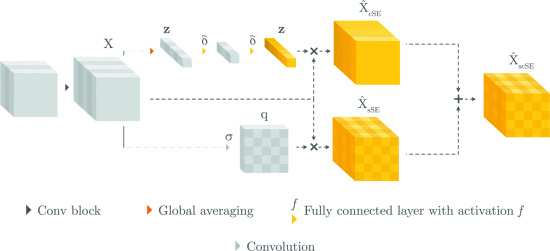

ref: https://ieeexplore.ieee.org/abstract/document/9425041

https://www.sciencedirect.com/science/article/pii/S0924271624003502#fig1

super-reso
https://github.com/lanha/DSen2/tree/master

https://github.com/Xilinx/DSRL ( https://openaccess.thecvf.com/content_CVPR_2020/papers/Wang_Dual_Super-Resolution_Learning_for_Semantic_Segmentation_CVPR_2020_paper.pdf)

attention:

https://arxiv.org/pdf/1612.03144

https://www.bilibili.com/read/cv28820964/

https://mp.ofweek.com/ai/a356714376197 (extend se block) https://github.com/murufeng/EPSANet/tree/master/models (https://arxiv.org/pdf/2105.14447)

https://arxiv.org/pdf/2106.08382

https://ieeexplore.ieee.org/abstract/document/10075555

In [56]:
import rasterio
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=1, threshold=sys.maxsize)

with rasterio.open(r'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/20m/labels/tiles_128/tile_4_26.tif') as src:
    target_data = src.read()  # (num_bands, H, W)
    nodata_value_label = src.nodata  # NoData value for the labels
    print(nodata_value_label)

    # Create a NoData mask for the target data
    if nodata_value_label is not None:
        mask = np.any(target_data == nodata_value_label, axis=0)  # Collapse bands to (H, W)
    else:
        mask = np.zeros_like(target_data[0], dtype=bool) 
    print(target_data.shape)
    print(mask.shape)
    
    target_tensor = torch.from_numpy(target_data).float()  # Shape: (num_output_channels, H, W)
    mask_tensor = torch.from_numpy(mask).bool()  # Shape: (H, W)
    
    # Expand the mask to match the number of channels in outputs and targets
    target_tensor = torch.stack((target_tensor, target_tensor))
    mask_tensor = torch.stack((mask_tensor, mask_tensor))
    print(target_tensor.shape)
    print(mask_tensor.shape)
    print(mask_tensor[:, 52, 64])
    expanded_mask = mask_tensor.unsqueeze(1).expand_as(target_tensor)  # Shape: (batch_size, num_channels, H, W)
    print(expanded_mask[:, :, 52, 64])

    # Exclude NoData pixels by applying the mask (keep only valid pixels)
    valid_target = target_tensor.masked_select(~expanded_mask).view(-1, target_tensor.size(1))
    print(valid_target)

-1.0
(9, 128, 128)
(128, 128)
torch.Size([2, 9, 128, 128])
torch.Size([2, 128, 128])
tensor([True, True])
tensor([[True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True]])
tensor([0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 

In [54]:
x = torch.randn((9, 2, 2))
x

tensor([[[-0.4,  1.5],
         [ 0.5,  1.4]],

        [[-0.6, -1.3],
         [ 0.8,  0.2]],

        [[ 2.8, -1.0],
         [ 0.2, -0.3]],

        [[-2.5, -1.2],
         [-0.4,  0.3]],

        [[ 2.7,  0.3],
         [-0.6, -0.6]],

        [[ 0.5, -1.8],
         [-0.9,  1.4]],

        [[-0.1,  0.8],
         [ 1.5, -0.6]],

        [[-0.2, -0.6],
         [-0.7,  1.0]],

        [[-0.3,  0.4],
         [ 0.2,  0.3]]])

#### MF

In [5]:
# fusion s2 data
class SE_Block(nn.Module):
    def __init__(self, ch_in, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 全局自适应池化
        self.fc = nn.Sequential(
            nn.Linear(ch_in, ch_in // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch_in // reduction, ch_in, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # squeeze操作
        y = self.fc(y).view(b, c, 1, 1) # FC获取通道注意力权重，是具有全局信息的
        return x * y.expand_as(x) # 注意力作用每一个通道上
    
class MF(nn.Module):  # Multi-Feature (MF) module for seasonal attention-based fusion
    def __init__(self, channels=13, reduction=16):  # Each season has 13 channels
        super(MF, self).__init__()
        # Channel attention for each season (spring, summer, autumn, winter)
        self.channels=channels
        self.reduction=reduction
        self.mask_map_spring = nn.Conv2d(self.channels, 1, 1, 1, 0, bias=True)
        self.mask_map_summer = nn.Conv2d(self.channels, 1, 1, 1, 0, bias=True)
        self.mask_map_autumn = nn.Conv2d(self.channels, 1, 1, 1, 0, bias=True)
        self.mask_map_winter = nn.Conv2d(self.channels, 1, 1, 1, 0, bias=True)
        
        # Shared bottleneck layers for each season
        self.bottleneck_spring = nn.Conv2d(self.channels, 16, 3, 1, 1, bias=False)
        self.bottleneck_summer = nn.Conv2d(self.channels, 16, 3, 1, 1, bias=False)
        self.bottleneck_autumn = nn.Conv2d(self.channels, 16, 3, 1, 1, bias=False)
        self.bottleneck_winter = nn.Conv2d(self.channels, 16, 3, 1, 1, bias=False)
        
        # Final SE Block for channel attention across all seasons
        self.se = SE_Block(64, self.reduction)  # Since we have 4 seasons with 16 channels each, we get a total of 64 channels

    def forward(self, x):  # x is a list of 4 inputs (spring, summer, autumn, winter)
        spring, summer, autumn, winter = x  # Unpack the inputs

        # Apply attention maps
        spring_mask = torch.mul(self.mask_map_spring(spring).repeat(1, self.channels, 1, 1), spring)
        summer_mask = torch.mul(self.mask_map_summer(summer).repeat(1, self.channels, 1, 1), summer)
        autumn_mask = torch.mul(self.mask_map_autumn(autumn).repeat(1, self.channels, 1, 1), autumn)
        winter_mask = torch.mul(self.mask_map_winter(winter).repeat(1, self.channels, 1, 1), winter)

        # Apply bottleneck layers
        spring_features = self.bottleneck_spring(spring_mask)
        summer_features = self.bottleneck_summer(summer_mask)
        autumn_features = self.bottleneck_autumn(autumn_mask)
        winter_features = self.bottleneck_winter(winter_mask)

        # Concatenate features from all seasons
        combined_features = torch.cat([spring_features, summer_features, autumn_features, winter_features], dim=1)

        # Apply SE Block for channel-wise attention
        out = self.se(combined_features)

        return out


#### ResidualBlock

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)  # Adjust channel dimensions if necessary

    def forward(self, x):
        identity = self.skip(x)  # Skip connection
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity  # Add skip connection to the output
        return self.relu(out)

#### model

In [7]:
# Updating UNet to incorporate residual connections and MF module
class ResUNet_MF(pl.LightningModule):
    def __init__(self, n_bands=13, out_channels=9, use_mf=False, use_residual=False, optimizer_type="adam", learning_rate=1e-3, scheduler_type=None, scheduler_params=None):
        """
        Args:
            n_bands (int): Number of input channels (bands) for each season.
            out_channels (int): Number of output channels.
            use_mf (bool): Whether to use the MF module.
            use_residual (bool): Whether to use Residual connections in U-Net blocks.
            optimizer_type (str): Type of optimizer ('adam', 'sgd', etc.).
            learning_rate (float): Learning rate for the optimizer.
            scheduler_type (str): Type of scheduler ('plateau', etc.).
            scheduler_params (dict): Parameters for the scheduler (e.g., 'patience', 'factor' for ReduceLROnPlateau).
        """
        super(ResUNet_MF, self).__init__()

        self.use_mf = use_mf
        self.use_residual = use_residual

        if self.use_mf:
            # MF Module for seasonal fusion (each season has `n_bands` channels)
            self.mf_module = MF(channels=n_bands)
            total_input_channels = 64  # MF module outputs 64 channels after processing four seasons
        else:
            total_input_channels = n_bands * 4  # If no MF module, concatenating all seasons directly

        # Define the U-Net architecture with or without Residual connections
        if self.use_residual:
            self.enc_conv0 = ResidualBlock(total_input_channels, 64)
            self.enc_conv1 = ResidualBlock(64, 128)
            self.enc_conv2 = ResidualBlock(128, 256)
            self.enc_conv3 = ResidualBlock(256, 512)
            self.dec_conv3 = ResidualBlock(512, 256)
            self.dec_conv2 = ResidualBlock(256, 128)
            self.dec_conv1 = ResidualBlock(128, 64)
        else:
            self.enc_conv0 = nn.Conv2d(total_input_channels, 64, kernel_size=3, padding=1)
            self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
            self.dec_conv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
            self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
            self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.dec_conv0 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)  # Output layer
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Loss and learning rate
        self.learning_rate = learning_rate
        self.criterion = MaskedMSELoss()

        # Optimizer and scheduler types
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type
        self.scheduler_params = scheduler_params if scheduler_params else {}
        
        self.save_hyperparameters()

    def forward(self, inputs):
        # Optionally pass inputs through MF module
        if self.use_mf:
            # Apply the MF module first to extract features from input
            spring, summer, fall, winter = inputs  # Unpack the individual datasets
            # Process through the MF module
            fused_features = self.mf_module([spring, summer, fall, winter])
        else:
            # Concatenate all seasons directly if no MF module
            fused_features = torch.cat(inputs, dim=1)

        # U-Net forward pass (with or without residual connections)
        x1 = F.relu(self.enc_conv0(fused_features))
        x2 = self.pool(x1)
        x2 = F.relu(self.enc_conv1(x2))
        x3 = self.pool(x2)
        x3 = F.relu(self.enc_conv2(x3))
        x4 = self.pool(x3)
        x4 = F.relu(self.enc_conv3(x4))

        x = self.up(x4)
        x = F.relu(self.dec_conv3(x))
        x = self.up(x)
        x = F.relu(self.dec_conv2(x))
        x = self.up(x)
        x = F.relu(self.dec_conv1(x))
        x = self.dec_conv0(x)  # Output layer (no activation here)

        return x
    
    def compute_loss_and_metrics(self, outputs, targets, masks, stage="val"):
        """
        Computes the masked loss, R² score, and logs the metrics.

        Args:
        - outputs: Predicted values (batch_size, num_channels, H, W)
        - targets: Ground truth values (batch_size, num_channels, H, W)
        - masks: Boolean mask indicating NoData pixels (batch_size, H, W)
        - stage: One of 'train', 'val', or 'test', used for logging purposes.

        Returns:
        - loss: The computed masked loss.
        """
        
        # Expand the mask to match the number of channels in outputs and targets
        expanded_mask = masks.unsqueeze(1).expand_as(outputs)  # Shape: (batch_size, num_channels, H, W)

        # Exclude NoData pixels by applying the mask (keep only valid pixels)
        valid_outputs = outputs.masked_select(~expanded_mask).view(-1, outputs.size(1))
        valid_targets = targets.masked_select(~expanded_mask).view(-1, targets.size(1))

        # Compute the masked loss
        loss = self.criterion(outputs, targets, masks)

        # Calculate R² score for valid pixels
        r2 = r2_score_torch(valid_targets, valid_outputs)

        # Log the loss and R² score
        self.log(f'{stage}_loss', loss, logger=True)
        self.log(f'{stage}_r2', r2, logger=True, prog_bar=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass
        
        return self.compute_loss_and_metrics(outputs, targets, masks, stage="train")

    def validation_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass
        
        return self.compute_loss_and_metrics(outputs, targets, masks, stage="val")
    
    def test_step(self, batch, batch_idx):
        inputs, targets, masks = batch
        outputs = self(inputs)  # Forward pass

        return self.compute_loss_and_metrics(outputs, targets, masks, stage="test")
    
    def configure_optimizers(self):
        # Choose the optimizer based on input parameter
        if self.optimizer_type == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_type == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        else:
            raise ValueError(f"Unknown optimizer type: {self.optimizer_type}")

        # Configure the scheduler based on the input parameter
        if self.scheduler_type == "plateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, **self.scheduler_params
            )
            return {
                'optimizer': optimizer,
                'lr_scheduler': {
                    'scheduler': scheduler,
                    'monitor': 'val_loss',  # Reduce learning rate when 'val_loss' plateaus
                }
            }
        else:
            return optimizer

#### dataset

In [8]:
class TreeSpeciesDataset(Dataset):
    def __init__(self, tile_names, processed_dir, datasets):
        """
        Args:
            tile_names (list): List of tile filenames to load.
            processed_dir (str): Base directory containing the processed data folders.
            datasets (list): List of dataset folder names to include (e.g., ['s2/spring', 's2/summer', 'topo', 'climate']).
        """
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets = datasets  # List of dataset folder names
        
        # Calculate number of bands by inspecting the first tile of the first dataset
        example_file = os.path.join(self.processed_dir, datasets[0], tile_names[0])
        with rasterio.open(example_file) as src:
            self.n_bands = src.count

    def __len__(self):
        return len(self.tile_names)

    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        input_data_list = []

        # Load data from each dataset (spring, summer, fall, winter, etc.)
        for dataset in self.datasets:
            dataset_path = os.path.join(self.processed_dir, dataset, tile_name)
            with rasterio.open(dataset_path) as src:
                input_data = src.read()  # Read the bands (num_bands, H, W)
                input_data_list.append(torch.from_numpy(input_data).float())  # Append each season's tensor to the list

        # Load the corresponding label (target species composition)
        label_path = os.path.join(self.processed_dir, 'labels/tiles_128', tile_name)
        
        with rasterio.open(label_path) as src:
            target_data = src.read()  # (num_bands, H, W)
            nodata_value_label = src.nodata  # NoData value for the labels

            # Create a NoData mask for the target data
            if nodata_value_label is not None:
                mask = np.any(target_data == nodata_value_label, axis=0)  # Collapse bands to (H, W)
            else:
                mask = np.zeros_like(target_data[0], dtype=bool)  # Assume all valid if no NoData value

        # Convert the target and mask to PyTorch tensors
        target_tensor = torch.from_numpy(target_data).float()  # Shape: (num_output_channels, H, W)
        mask_tensor = torch.from_numpy(mask).bool()  # Shape: (H, W)

        # Return the list of input tensors for each season, the target tensor, and the mask tensor
        return input_data_list, target_tensor, mask_tensor

class TreeSpeciesDataModule(pl.LightningDataModule):
    def __init__(self, tile_names, processed_dir, datasets_to_use, batch_size=4, num_workers=4):
        """
        Args:
            tile_names (dict): Dictionary with 'train', 'val', and 'test' keys containing lists of tile filenames to load.
            processed_dir (str): Directory where processed data is located.
            datasets_to_use (list): List of dataset names to include (e.g., ['s2/spring', 's2/summer', ...]).
            batch_size (int): Batch size for DataLoader.
            num_workers (int): Number of workers for DataLoader.
        """
        super().__init__()
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets_to_use = datasets_to_use
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        """
        Sets up the dataset for train, validation, and test splits.
        """
        # Create datasets for train, validation, and test
        self.train_dataset = TreeSpeciesDataset(self.tile_names['train'], self.processed_dir, self.datasets_to_use)
        self.val_dataset = TreeSpeciesDataset(self.tile_names['val'], self.processed_dir, self.datasets_to_use)
        self.test_dataset = TreeSpeciesDataset(self.tile_names['test'], self.processed_dir, self.datasets_to_use)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [9]:
def load_tile_names(file_path):
    """
    Load tile names from a .txt file.

    Args:
        file_path (str): Path to the .txt file.

    Returns:
        tile_names (list): List of tile names.
    """
    with open(file_path, 'r') as f:
        tile_names = f.read().splitlines()
    return tile_names

#### training

In [10]:
def train(datasets_to_use, resolution, log_name, num_epoch=10, use_mf=True, use_residual=True):
    wandb.init()
    # Tile names for train, validation, and test
    tile_names = {
        'train': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/train_tiles.txt'),
        'val': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/val_tiles.txt'),
        'test': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/test_tiles.txt')
    }
    # Initialize the DataModule
    data_module = TreeSpeciesDataModule(
        tile_names=tile_names,
        processed_dir=f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m',  # Base directory where the datasets are stored
        datasets_to_use=datasets_to_use,
        batch_size=8,
        num_workers=4
    )
    
    # Call setup explicitly to initialize datasets
    data_module.setup(stage='fit')
    # Access `n_bands` after the dataset has been initialized
    n_bands = data_module.train_dataset.n_bands
    
    # Use the calculated input channels from the DataModule to initialize the model
    model = ResUNet_MF(
        n_bands=n_bands,  # Example channel config
        out_channels=9,
        use_mf=use_mf,
        use_residual=use_residual,
        optimizer_type="adam",
        learning_rate=1e-3,
        scheduler_type="plateau",
        scheduler_params={'patience': 3, 'factor': 0.5}
    )

    # Define a checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',  # Track the validation loss
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Only save the best model
        mode='min'  # We want to minimize the validation loss
    )

    csv_logger = CSVLogger(save_dir='logs/csv_logs', name=log_name)
    wandb_logger = WandbLogger(name=log_name, save_dir='logs/wandb_logs', offline=True)
    
    # Create a PyTorch Lightning Trainer
    trainer = Trainer(
        max_epochs=num_epoch,
        logger=[wandb_logger, csv_logger],
        callbacks=[checkpoint_callback]
    )
    wandb_logger.log_text('parameters.txt', dataframe=pd.DataFrame({'datasets': [datasets_to_use], 'num_epoches': num_epoch, 'resolution': resolution}))

    # Train the model
    trainer.fit(model, data_module)

    # Test the model after training
    trainer.test(model, data_module)

    # Save the best model after training
    trainer.save_checkpoint(f"logs/checkpoints/{log_name}/final_model.pt")
    # Load the saved model
    #model = UNetLightning.load_from_checkpoint("final_model.ckpt")
    wandb.finish()

In [11]:
!wandb offline

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


In [12]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 20, 'Uet_S4', num_epoch=200, use_mf=False, use_residual=False)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 20.8 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train


Epoch 199: 100%|██████████| 186/186 [00:49<00:00,  3.77it/s, v_num=fa_1, train_r2=0.325, val_r2=0.375]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 186/186 [00:49<00:00,  3.77it/s, v_num=fa_1, train_r2=0.325, val_r2=0.375]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:07<00:00,  5.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03309273719787598    │
│          test_r2          │    0.3700243830680847     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
test_loss,▁
test_r2,▁
train_loss,▃▄▂▁▂▃▅▃▃▄▄▅▂█▂▃▇▃▃▃▄▂▇▃▂▃▂▂▅▃▂▃▃▃▄▄▅▃▃▃
train_r2,▆▆▆▂▄▆▇▆▃▅▆▄▆▇▄▃█▇█▆▄▇▅▅▇▄▃█▁▄▄▅▁▄▄▄▆▇▆█
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
val_loss,█▇▆▆▅▅▃▁▂▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_r2,▃▂█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,200
test_loss,0.03309
test_r2,0.37002


In [13]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 10, 'Uet_S4_10m', num_epoch=200, use_mf=False, use_residual=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | Conv2d        | 27.7 K | train
1  | enc_conv1 | Conv2d        | 73.9 K | train
2  | enc_conv2 | Conv2d        | 295 K  | train
3  | enc_conv3 | Conv2d        | 1.2 M  | train
4  | dec_conv3 | Conv2d        | 1.2 M  | train
5  | dec_conv2 | Conv2d        | 295 K  | train
6  | dec_conv1 | Conv2d        | 73.8 K | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 199: 100%|██████████| 713/713 [03:34<00:00,  3.32it/s, v_num=dw_0, train_r2=0.279, val_r2=0.367]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 713/713 [03:34<00:00,  3.32it/s, v_num=dw_0, train_r2=0.279, val_r2=0.367]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 153/153 [00:38<00:00,  4.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03408826142549515    │
│          test_r2          │    0.37713494896888733    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇█████
test_loss,▁
test_r2,▁
train_loss,▃▅▃▂▄▄▁▂▃▃▄▁▃▁▅▃▅▄▃▂▁█▄▂▄▄▄▃▃▂▂▆▄▅▃▂▄▃▄▄
train_r2,▅▅██▆▆▇▃▅▆▅▇▁▅▃▆▇▅▆▆▅▆▅▅▇▅▃▃▆▅▄▆▂▃▇▂▂▆▇▄
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
val_loss,▁█▅▃▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_r2,▂██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
test_loss,0.03409
test_r2,0.37713


In [37]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 20, 'RUet_S4', num_epoch=200, use_mf=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | enc_conv0 | ResidualBlock | 60.1 K | train
1  | enc_conv1 | ResidualBlock | 229 K  | train
2  | enc_conv2 | ResidualBlock | 918 K  | train
3  | enc_conv3 | ResidualBlock | 3.7 M  | train
4  | dec_conv3 | ResidualBlock | 1.9 M  | train
5  | dec_conv2 | ResidualBlock | 475 K  | train
6  | dec_conv1 | ResidualBlock | 118 K  | train
7  | dec_conv0 | Conv2d        | 5.2 K  | train
8  | pool      | MaxPool2d     | 0      | train
9  | up        | Upsa

Epoch 99: 100%|██████████| 186/186 [00:50<00:00,  3.71it/s, v_num=ec_0, train_r2=0.865, val_r2=0.516] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 186/186 [00:50<00:00,  3.71it/s, v_num=ec_0, train_r2=0.865, val_r2=0.516]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.024757172912359238    │
│          test_r2          │    0.5483073592185974     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
test_loss,▁
test_r2,▁
train_loss,█▃▅▆█▅▇▆▅▃▃▂▂▂▂▂▂▂▂▃▃▁▂▁▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂
train_r2,▁▃▃▆▆▆▆▆▅▆▇▆▇█▇▆▇██▇██▇██▇▇▇▇▇▇█▇▇▇▇▇▇██
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_loss,█▄▄▃▂▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_r2,▁▄▂▇▇▅▁███▇▇█▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,100
test_loss,0.02476
test_r2,0.54831


In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 10, 'RUet_S4_10m', num_epoch=200, use_mf=False)

In [10]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 20, 'Uet_S4_MF', num_epoch=200, use_residual=False)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | mf_module | MF            | 5.7 K  | train
1  | enc_conv0 | Conv2d        | 36.9 K | train


Epoch 0:  39%|███▊      | 72/186 [00:16<00:25,  4.45it/s, v_num=ny_5, train_r2=-0.902]  

/home/yuwei-linux/code/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09816724807024002    │
│          test_r2          │    -0.7892652153968811    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁
test_loss,▁
test_r2,▁
train_loss,▁
train_r2,▁
trainer/global_step,▁█
epoch,0
test_loss,0.09817
test_r2,-0.78927
train_loss,0.12196
train_r2,-0.89027


In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 10, 'Uet_S4_10m_MF', num_epoch=200, use_residual=False)

In [ ]:
# User specifies which datasets to use
datasets_to_use = ['rmf_s2/spring/tiles_128','rmf_s2/summer/tiles_128','rmf_s2/fall/tiles_128','rmf_s2/winter/tiles_128']

train(datasets_to_use, 20, 'RUet_S4_MF', num_epoch=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | mf_module | MF            | 5.7 K  | train
1  | enc_conv0 | ResidualBlock | 78.0 K | train
2  | enc_conv1 | ResidualBlock | 229 K  | train
3  | enc_conv2 | ResidualBlock | 918 K  | train
4  | enc_conv3 | ResidualBlock | 3.7 M  | train
5  | dec_conv3 | ResidualBlock | 1.9 M  | train
6  | dec_conv2 | ResidualBlock | 475 K  | train
7  | dec_conv1 | ResidualBlock | 118 K  | train
8  | dec_conv0 | Conv2d        | 5.2 K  | train
9  | pool      | MaxP

Epoch 99: 100%|██████████| 186/186 [00:52<00:00,  3.57it/s, v_num=8b_3, train_r2=0.546, val_r2=0.348]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 186/186 [00:52<00:00,  3.52it/s, v_num=8b_3, train_r2=0.546, val_r2=0.348]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03299941495060921    │
│          test_r2          │    0.37007516622543335    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
test_loss,▁
test_r2,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆██████████████████████████████████████
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆██████████████████████████████████████
epoch,100
test_loss,0.033
test_r2,0.37008


#### full UNET

In [16]:
!python train.py --data_dir '/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed' --resolution 20 --log_name 'Unet_S4_20m' --num_epoch 200 --batch_size 4 --mode 'img'

wandb: Tracking run with wandb version 0.18.1
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | 

Unet 10m

In [ ]:
!python train.py --data_dir '/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed' --resolution 10 --log_name 'Unet_S4_10m' --num_epoch 200 --batch_size 4 --mode 'img'

```
| Name      | Type          | Params | Mode |
----------------------------------------------------
| model     | UNet          | 17.3 M | train|
| criterion | MaskedMSELoss | 0      | train|
----------------------------------------------------
```
69.158    Total estimated model params size (MB)

Epoch 11:  32%|███████████████▏                                | 225/713 [00:45<01:38,  4.97it/s, v_num=x3_0, train_r2=0.644, val_r2=0.530]
Epoch 55:  80%|██████████████████████████████████████▏         | 567/713 [02:45<00:42,  3.43it/s, v_num=x3_0, train_r2=0.509, val_r2=0.645]
Epoch 70: 100%|████████████████████████████████████████████████| 713/713 [03:24<00:00,  3.48it/s, v_num=x3_0, train_r2=0.684, val_r2=0.650

+ Residual

In [21]:
!python train.py --data_dir '/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed' --resolution 20 --log_name 'ResUnet_S4_20m' --num_epoch 200 --batch_size 4 --mode 'img' --use_residual

wandb: Tracking run with wandb version 0.18.1
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/yuwei-linux/code/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | 

+ MF

+MF+Residual connections

In [ ]:
!python train.py --data_dir '/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed' --resolution 20 --log_name 'ResUnet_S4_20m_MF' --num_epoch 200 --batch_size 4 --mode 'img' --use_mf --use_residual

```
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | mf_module | MF            | 5.7 K  | train
1 | model     | ResUnet       | 3.3 M  | train
2 | criterion | MaskedMSELoss | 0      | train
----------------------------------------------------
```
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.096    Total estimated model params size (MB)

Epoch 199: 100%|███████████████████████████████████████████████| 186/186 [00:45<00:00,  4.05it/s, v_num=hk_4, train_r2=0.852, val_r2=0.604]`Trainer.fit` stopped: `max_epochs=200` reached.                                                                                           

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.66it/s]

```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.020061282441020012    │
│          test_r2          │    0.6315046548843384     │
└───────────────────────────┴───────────────────────────┘
```

### pts stream

In [1]:
!pip install laspy[laszip] seaborn rasterio torch

   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   ------- -------------------------------- 5.0/25.3 MB 23.1 MB/s eta 0:00:01
   -------------- ------------------------- 8.9/25.3 MB 21.3 MB/s eta 0:00:01
   --------------------- ------------------ 13.9/25.3 MB 22.3 MB/s eta 0:00:01
   ----------------------------- ---------- 18.9/25.3 MB 22.5 MB/s eta 0:00:01
   -------------------------------------- - 24.4/25.3 MB 23.0 MB/s eta 0:00:01
   ---------------------------------------  25.2/25.3 MB 22.8 MB/s eta 0:00:01
   ---------------------------------------  25.2/25.3 MB 22.8 MB/s eta 0:00:01
   ---------------------------------------- 25.3/25.3 MB 16.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
    --------------------------------------- 5.0/203.1 MB 27.4 MB/s eta 0:00:08
   - -------------------------------------- 9.7/203.1 MB 25.2 MB/s eta 0:00:08
   -- ------------------------------------- 14.2/203.1 MB 23.4 MB/s eta

In [2]:
!pip install pytorch_lightning lightning

   ---------------------------------------- 0.0/815.2 kB ? eta -:--:--
   --------------------------------------- 815.2/815.2 kB 11.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/811.0 kB ? eta -:--:--
   --------------------------------------- 811.0/811.0 kB 17.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/890.5 kB ? eta -:--:--
   --------------------------------------- 890.5/890.5 kB 19.6 MB/s eta 0:00:00


#### Dataset

In [ ]:
import laspy
import torch
import rasterio
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import os
import numpy as np

class TreeSpeciesPointCloudDataset(Dataset):
    def __init__(self, tile_names, processed_dir, datasets, point_cloud_dir, imagery=True):
        """
        Args:
            tile_names (list): List of tile filenames to load.
            processed_dir (str): Base directory containing the processed imagery data.
            datasets (list): List of dataset folder names to include (e.g., ['s2/spring', 's2/summer']).
            point_cloud_dir (str): Directory containing point clouds in .laz format.
            imagery (bool): Whether to load imagery data. If False, only point clouds are loaded.
        """
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets = datasets  # List of dataset folder names
        self.point_cloud_dir = point_cloud_dir  # Directory for point clouds
        self.imagery = imagery

        # If imagery is to be loaded, calculate number of bands
        if self.imagery:
            example_file = os.path.join(self.processed_dir, datasets[0], tile_names[0])
            with rasterio.open(example_file) as src:
                self.n_bands = src.count
        else:
            self.n_bands = None  # Imagery is not being loaded

    def __len__(self):
        return len(self.tile_names)

    def _load_point_cloud(self, tile_name, row_idx, col_idx):
        """
        Load and filter the point cloud for the given tile_name, row_idx, and col_idx.
        Filter out points where classification == 0.
        If all points are invalid, return a dummy point cloud.
        """
        point_cloud_file = os.path.join(self.point_cloud_dir, f"{tile_name}_{row_idx}_{col_idx}.laz")

        # Use laspy to read the .laz file
        with laspy.open(point_cloud_file) as f:
            point_cloud = f.read()

        # Extract points and filter out points where classification == 0 (invalid points)
        valid_mask = point_cloud.classification != 0  # Valid points have classification != 0

        if valid_mask.sum() > 0:  # Check if there are any valid points
            points = np.vstack([point_cloud.x[valid_mask], point_cloud.y[valid_mask], point_cloud.z[valid_mask]]).T
        else:
            # If no valid points, return a dummy point cloud (e.g., all zeros)
            points = np.zeros((1, 3))  # Assuming 3D point cloud (x, y, z)

        return torch.from_numpy(points).float(), valid_mask

    def _load_imagery(self, tile_name):
        """
        Load the imagery for the given tile_name and create a NoData mask.
        """
        input_data_list = []

        # Load data from each dataset (spring, summer, fall, winter, etc.)
        for dataset in self.datasets:
            dataset_path = os.path.join(self.processed_dir, dataset, tile_name)
            with rasterio.open(dataset_path) as src:
                input_data = src.read()  # Read the bands (num_bands, H, W)
                nodata_value = src.nodata

                # Create a NoData mask for the imagery
                if nodata_value is not None:
                    mask = np.any(input_data == nodata_value, axis=0)  # Collapse bands to (H, W)
                else:
                    mask = np.zeros_like(input_data[0], dtype=bool)  # Assume all valid if no NoData value

                input_data_list.append(torch.from_numpy(input_data).float())  # Append each season's tensor to the list

        # Combine masks from all datasets
        combined_imagery_mask = torch.from_numpy(mask).bool()

        return input_data_list, combined_imagery_mask

    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]

        # Load imagery data if requested
        if self.imagery:
            input_data_list, imagery_mask = self._load_imagery(tile_name)
        else:
            imagery_mask = None  # No imagery mask

        # Load the corresponding label (target species composition)
        label_path = os.path.join(self.processed_dir, 'labels/tiles_128', tile_name)
        with rasterio.open(label_path) as src:
            target_data = src.read()  # (num_bands, H, W)
            nodata_value_label = src.nodata  # NoData value for the labels

            # Create a NoData mask for the labels
            if nodata_value_label is not None:
                label_mask = np.any(target_data == nodata_value_label, axis=0)  # Collapse bands to (H, W)
            else:
                label_mask = np.zeros_like(target_data[0], dtype=bool)  # Assume all valid if no NoData value

        # Initialize the combined mask (start with label mask)
        combined_mask = torch.from_numpy(label_mask).bool()

        # If imagery is loaded, combine imagery mask with label mask
        if self.imagery:
            combined_mask = combined_mask | imagery_mask

        # Load point clouds for each pixel in the tile and update the combined mask
        if self.imagery:
            H, W = input_data_list[0].shape[1], input_data_list[0].shape[2]  # Get the height and width of the tile
        else:
            # If imagery is not loaded, we need to determine H and W from the labels
            H, W = target_data.shape[1], target_data.shape[2]

        point_clouds = []

        for row_idx in range(H):
            for col_idx in range(W):
                if not combined_mask[row_idx, col_idx]:  # If pixel is valid
                    point_cloud, valid_pc_mask = self._load_point_cloud(tile_name, row_idx, col_idx)

                    # If the point cloud is invalid (classification == 0), update combined mask
                    if point_cloud.size(0) > 0 and valid_pc_mask.sum() > 0:  # Ensure point cloud is valid
                        point_clouds.append(point_cloud)
                    else:
                        combined_mask[row_idx, col_idx] = True  # Mark as invalid in the combined mask
                        point_clouds.append(torch.zeros((1, 3)))  # Append a dummy point cloud
                else:
                    point_clouds.append(torch.zeros((1, 3)))  # Append a dummy point cloud for invalid pixels

        # Convert the list of point clouds to a tensor (H * W, num_points, point_features)
        point_clouds_tensor = torch.stack(point_clouds).float()  # Shape: (H * W, num_points, point_features)

        # Convert the target and mask to PyTorch tensors
        target_tensor = torch.from_numpy(target_data).float()  # Shape: (num_output_channels, H, W)

        # Return the data according to whether imagery is loaded
        if self.imagery:
            return input_data_list, point_clouds_tensor, target_tensor, combined_mask
        else:
            return point_clouds_tensor, target_tensor, combined_mask

In [ ]:
class TreeSpeciesPointCloudDataModule(pl.LightningDataModule):
    def __init__(self, tile_names, processed_dir, datasets_to_use, point_cloud_dir, imagery=True, batch_size=4, num_workers=4):
        """
        Args:
            tile_names (dict): Dictionary with 'train', 'val', and 'test' keys containing lists of tile filenames to load.
            processed_dir (str): Directory where processed data is located.
            datasets_to_use (list): List of dataset names to include (e.g., ['s2/spring', 's2/summer']).
            point_cloud_dir (str): Directory containing point cloud data in .laz format.
            imagery (bool): Whether to load imagery data. If False, only point clouds are loaded.
            batch_size (int): Batch size for DataLoader.
            num_workers (int): Number of workers for DataLoader.
        """
        super().__init__()
        self.tile_names = tile_names
        self.processed_dir = processed_dir
        self.datasets_to_use = datasets_to_use
        self.point_cloud_dir = point_cloud_dir
        self.imagery = imagery
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        """
        Sets up the dataset for train, validation, and test splits.
        """
        # Create datasets for train, validation, and test
        self.train_dataset = TreeSpeciesPointCloudDataset(
            self.tile_names['train'],
            self.processed_dir,
            self.datasets_to_use,
            self.point_cloud_dir,
            imagery=self.imagery
        )
        self.val_dataset = TreeSpeciesPointCloudDataset(
            self.tile_names['val'],
            self.processed_dir,
            self.datasets_to_use,
            self.point_cloud_dir,
            imagery=self.imagery
        )
        self.test_dataset = TreeSpeciesPointCloudDataset(
            self.tile_names['test'],
            self.processed_dir,
            self.datasets_to_use,
            self.point_cloud_dir,
            imagery=self.imagery
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


#### PointNext

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from pointnext import pointnext_s, PointNext, PointNextDecoder

class PointNeXtLightning(pl.LightningModule):
    def __init__(self, num_classes=9, learning_rate=1e-3):
        super(PointNeXtLightning, self).__init__()
        
        # Load PointNeXt backbone from torch-points3d
        encoder = pointnext_s(in_dim=3)
        self.pointnext = PointNext(num_classes, encoder=encoder, decoder=PointNextDecoder(encoder_dims=encoder.encoder_dims))
        
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, point_cloud):
        """
        Args:
            point_cloud: Input point cloud tensor (B, N, 3), where:
            B = Batch size, N = Number of points, 3 = (x, y, z) coordinates
        
        Returns:
            logits: Class logits for each point (B, N, num_classes)
        """
        return self.pointnext(point_cloud)
    
    def training_step(self, batch, batch_idx):
        point_clouds, targets, mask = batch
        outputs = self(point_clouds)  # Forward pass
        
        # Compute loss
        loss = self.criterion(outputs, targets.long())
        
        # Log training loss
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        point_clouds, targets, mask = batch
        outputs = self(point_clouds)  # Forward pass
        
        # Compute loss
        loss = self.criterion(outputs, targets.long())
        
        # Log validation loss
        self.log('val_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Example scheduler
        
        return [optimizer], [scheduler]


In [13]:
from pointnext import PointNext, PointNextDecoder, pointnext_s

/home/yuwei-linux/code/venv/lib/python3.10/site-packages/pointnext/ops.py:118: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


#### train

In [ ]:
def train(datasets_to_use, resolution, log_name, num_epoch=10, use_mf=True, use_residual=True):
    wandb.init()
    # Tile names for train, validation, and test
    tile_names = {
        'train': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/train_tiles.txt'),
        'val': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/val_tiles.txt'),
        'test': load_tile_names(f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m/dataset/test_tiles.txt')
    }
    # Instantiate data module (imagery=False to only load point clouds)
    data_module = TreeSpeciesPointCloudDataModule(
        tile_names=tile_names,
        processed_dir=f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m',
        datasets_to_use=[],  # No need for imagery datasets
        point_cloud_dir=f'/mnt/g/rmf/m3f_spl/laz_plots',
        imagery=False,  # Only point cloud
        batch_size=8,
        num_workers=4
    )

    # Initialize the model
    model = PointNeXtLightning(num_classes=9, learning_rate=1e-3)

    # Define a checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',  # Track the validation loss
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Only save the best model
        mode='min'  # We want to minimize the validation loss
    )

    csv_logger = CSVLogger(save_dir='logs/csv_logs', name=log_name)
    wandb_logger = WandbLogger(name=log_name, save_dir='logs/wandb_logs', offline=True)
    
    # Create a PyTorch Lightning Trainer
    trainer = Trainer(
        max_epochs=num_epoch,
        logger=[wandb_logger, csv_logger],
        callbacks=[checkpoint_callback]
    )
    wandb_logger.log_text('parameters.txt', dataframe=pd.DataFrame({'datasets': [datasets_to_use], 'num_epoches': num_epoch, 'resolution': resolution}))

    # Train the model
    trainer.fit(model, data_module)

    # Test the model after training
    trainer.test(model, data_module)

    # Save the best model after training
    trainer.save_checkpoint(f"logs/checkpoints/{log_name}/final_model.pt")
    # Load the saved model
    #model = UNetLightning.load_from_checkpoint("final_model.ckpt")
    wandb.finish()


In [ ]:
data_module = TreeSpeciesPointCloudDataModule(
    tile_names=tile_names,
    processed_dir=f'/mnt/d/Sync/research/tree_species_estimation/tree_dataset/rmf/processed/{resolution}m',
    datasets_to_use=[],  # No need for imagery datasets
    point_cloud_dir=f'/mnt/g/rmf/m3f_spl/laz_plots',
    imagery=True,  # Load imagery
    batch_size=4,
    num_workers=4
)

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        squared_errors = torch.square(y_pred - y_true)
        weighted_squared_errors = squared_errors * self.weights
        loss = torch.mean(weighted_squared_errors) # for multi-gpu, should it set to sum?
        return loss

def calc_loss(y_true, y_pred, weights):
    weighted_mse = WeightedMSELoss(weights)
    loss = weighted_mse(F.softmax(y_pred, dim=1), y_true)
    
    return loss

#### test

### visualise

In [ ]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()